# Predicting Customer Churn Probability For Fitness Centers
<a id='contents'></a>

**Contents:**

- [Project Objective](#projectobjective)
- [Data Description](#datadescription)
- [Import Required Libraries](#importrequiredlibraries)
- [Data preparation](#datapreparation)
- [Exploratory Data Analysis](#eda)
- [Customer Churn Prediction Model](#customerchurnpredictionmodel)
- [Customer Segmentation through Clustering](#customerclustering)
- [Project Sumary](#projectsumary)

<a id='projectobjective'></a>
## Project Objective:

- Learn to predict customer churn probability (at the next month level) for each client
- Identify typical customer profiles: highlight several distinct groups and characterize their key properties
- Analyze the main features that have the strongest impact on churn
- Formulate key findings and develop recommendations for improving customer relations:
  - identify target groups of clients;
  - Propose measures to reduce churn;
  - Determine other interaction features with customers.

<a id='datadescription'></a>
## Data Description

The `gym_churn.csv` file contains data for the month before churn and the churn fact for a specific month.

<table width="100%">
  <tr>
    <th><b>Feature's Name</b></th>
    <th><b>Data Description</b></th>
  </tr>
  <tr>
    <td><b>churn</b></td>
    <td>fact of churn in the current month</td>
  </tr>
  <tr>
    <td><b>gender</b></td>
    <td>gender</td>
  </tr>
  <tr>
    <td><b>near_location</b></td>
    <td>living or working in the area where the fitness center is located</td>
  </tr>
  <tr>
    <td><b>partner</b></td>
    <td>employee of a partner company of the club</td>
  </tr>
  <tr>
    <td><b>promo_friends</b></td>
    <td>fact of initial registration under the "bring a friend" promotion</td>
  </tr>
  <tr>
    <td><b>phone</b></td>
    <td>presence of a contact phone</td>
  </tr>
  <tr>
    <td><b>age</b></td>
    <td>age</td>
  </tr>
  <tr>
    <td><b>lifetime</b></td>
    <td>time since the first visit to the fitness center (in months)</td>
  </tr>
  <tr>
    <td><b>contract_period</b></td>
    <td>duration of the current active subscription (month, 3 months, 6 months, year)</td>
  </tr>
  <tr>
    <td><b>month_to_end_contract</b></td>
    <td>time until the end of the current active subscription (in months)</td>
  </tr>
  <tr>
    <td><b>group_visits</b></td>
    <td>fact of attending group classes</td>
  </tr>
  <tr>
    <td><b>avg_class_frequency_total</b></td>
    <td>average visit frequency per week over all time</td>
  </tr>
  <tr>
    <td><b>avg_class_frequency_current_month</b></td>
    <td>average visit frequency per week for the previous month</td>
  </tr>
  <tr>
    <td><b>avg_additional_charges_total</b></td>
    <td>total revenue from other services of the fitness center: cafe, sports</td>
  </tr>
</table>

<a id='importrequiredlibraries'></a>
## Import Required Libraries

In [1]:
import itertools
import math
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.figure_factory as ff
from plotly import graph_objects as go
from pandas.plotting import register_matplotlib_converters
from scipy.cluster.hierarchy import dendrogram, linkage
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score, silhouette_score
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier


register_matplotlib_converters()

[*<< to Contents*](#contents)

<a id='datapreparation'></a>
## Data Preparation

**Actions included:**

- checking and converting data types if necessary;
- normalization of string values, in our case, it only concerns column names;
- finding and handling duplicate observation;
- finding and handling missing values.

[*>> to Exploratory Data Analysis*](#eda)

In [2]:
#loading data
gym_df = pd.read_csv('data//gym_churn.csv')

In [3]:
#Let's output information about the dataframe's shape using the shape method
gym_df.shape

(4000, 14)

In [4]:
#Let's output the first 5 rows of our dataframe.
gym_df.head(5)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [5]:
#Data type checking 
gym_df.dtypes

gender                                 int64
Near_Location                          int64
Partner                                int64
Promo_friends                          int64
Phone                                  int64
Contract_period                        int64
Group_visits                           int64
Age                                    int64
Avg_additional_charges_total         float64
Month_to_end_contract                float64
Lifetime                               int64
Avg_class_frequency_total            float64
Avg_class_frequency_current_month    float64
Churn                                  int64
dtype: object

In [6]:
#Column names standardizing
gym_df.columns = gym_df.columns.str.lower()
gym_df.columns.tolist()

['gender',
 'near_location',
 'partner',
 'promo_friends',
 'phone',
 'contract_period',
 'group_visits',
 'age',
 'avg_additional_charges_total',
 'month_to_end_contract',
 'lifetime',
 'avg_class_frequency_total',
 'avg_class_frequency_current_month',
 'churn']

In [7]:
#Duplicate observations search
gym_df.duplicated().sum()

0

In [8]:
#Missed values search
gym_df.isna().sum()

gender                               0
near_location                        0
partner                              0
promo_friends                        0
phone                                0
contract_period                      0
group_visits                         0
age                                  0
avg_additional_charges_total         0
month_to_end_contract                0
lifetime                             0
avg_class_frequency_total            0
avg_class_frequency_current_month    0
churn                                0
dtype: int64

**Data Preparation: Sumary**

Initially, the dataframe consisted of 4000 rows (observations) and 13 columns (features) + 1 column (feature) - the target variable. All 13 features have numerical data types.

The following actions were taken during the data preparation:
- *checking and converting data types if necessary* - All data types are quantitative, although according to the data description, many of them were flags (a choice between two categories) and could be classified as categorical data. We decided not to change binary features, despite their categorical nature and the possibility of representing them as objects (data type object). This approach allows for effective processing and use of binary features in analysis and modeling as numerical data (int64, float64), without the need for additional transformations. This is a standard practice and ensures efficient data processing.

- *normalization of string values* - Since all our features have numerical data types, there was no need to standardize the values. The columns(features) names were standardized.

- *finding and handling duplicate observation* - The dataset does not contain duplicate observations.

- *finding and handling missing values* - The dataset does not contain missing observations.

[*<< to Data Preparation*](#datapreparation)

<a id='eda'></a>
## Exploratory Data Analysis

**Actions included:**

- studying the mean values and standard deviation;
- studying the mean values separately for two groups (churned/not churned);
- displaying a histogram and distribution of features for two groups (churned/not churned);
- studying the correlation between features.

[*>> to Customer Churn Predict Model*](#customerchurnpredictionmodel)

In [9]:
# Studying the means and standard deviations
gym_df.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


In [10]:
# Studying the mean values separately for two groups (churned/not churned)
gym_df.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


In [11]:
# Studying the standart deviation separately for two groups (churned/not churned)
gym_df.groupby('churn').std()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.499984,0.332933,0.498914,0.478144,0.295040,4.716942,0.498795,3.009933,99.801599,4.363522,3.874780,1.016006,1.018994
1,0.500118,0.422217,0.478837,0.387495,0.296204,2.132371,0.443448,2.895163,77.696419,1.964593,1.110799,0.694705,0.770237


Based on the analysis of mean values and standard deviations, we have identified several differences between clients who have remained at the fitness center and those who have discontinued their visits. Notably, clients who continue to visit the fitness center are, on average, older, more frequently participate in partner programs and 'bring a friend' promotions, have longer memberships, and show higher average visit frequencies.

To delve deeper into these differences, we will visualize them using three types of graphs. Barplots will be used for binary features to clearly demonstrate differences in counts and percentages between the groups. Density plots (Kdeplot) will be applied to continuous variables to illustrate how values are distributed among those who have stayed and those who have left, highlighting key trends. Additionally, boxplots will provide a detailed view of the distributional characteristics such as quartiles and outliers, offering a complementary perspective to the density plots.

These visualizations will deepen our understanding of the factors influencing client loyalty and assist in planning retention strategies.

In [12]:
#Let's create a list of feature names that are quantitative not only by data type but also in essence
numerical_features = ['age', 'avg_additional_charges_total', 'month_to_end_contract',
                   'lifetime', 'avg_class_frequency_total', 'avg_class_frequency_current_month']

#And a list of flag features that can be classified as categorical
binary_features = [col_name for col_name in gym_df.columns if col_name not in numerical_features and col_name != 'churn']

The feature `contract_period` differs from binary features, as it is categorical with three unique values representing different contract durations (3 months, 6 months, and 1 year). Therefore, `contract_period` will be considered separately to better understand its impact on customer loyalty and their propensity to churn.

In [13]:
binary_features_bin = binary_features.copy()
binary_features_bin.remove('contract_period')

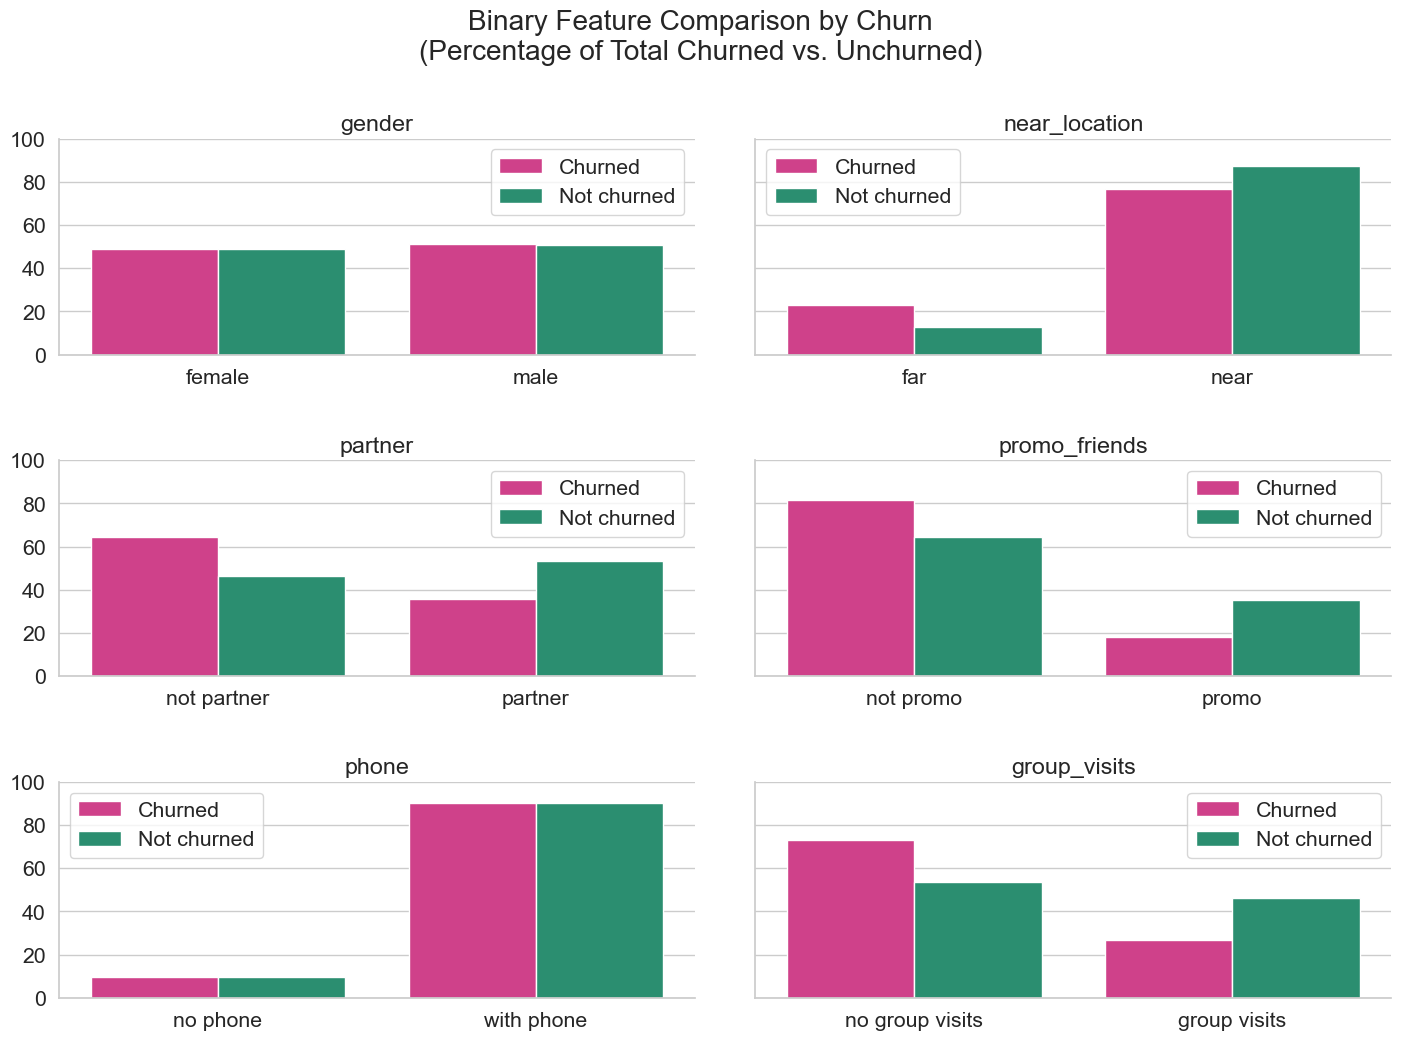

In [14]:
# Set the aesthetic style of the plots and scale font elements
sns.set(style='whitegrid', font_scale=1.4)

# Calculate coordinates for subplot grid positions dynamically based on the number of binary features
y_coordinates = [i // 2 for i in range(len(binary_features_bin))]
x_coordinates = [i % 2 for i in range(len(binary_features_bin))]

# Initialize the figure object and grid specification for subplots
n_rows = math.ceil(len(binary_features_bin) / 2)
fg = plt.figure(figsize=(14, 10))
gs = gridspec.GridSpec(ncols=2, nrows=n_rows, figure=fg)

# Set the main title of the figure with a specific vertical offset
plt.suptitle('Binary Feature Comparison by Churn\n(Percentage of Total Churned vs. Unchurned)', y=1.03)

# Define custom x-axis tick labels for each binary feature based on their nature
x_ticks = [['female', 'male'], ['far', 'near'], ['not partner', 'partner'], ['not promo', 'promo'], ['no phone', 'with phone'], ['no group visits', 'group visits']]

# Loop over each binary feature to create individual subplots
for i in range(len(binary_features_bin)):
    # Add a subplot in the appropriate grid position
    fig_ax = fg.add_subplot(gs[y_coordinates[i], x_coordinates[i]])
    feature = binary_features_bin[i]
    
    # Group data by churn status and feature, then count occurrences
    df = gym_df.groupby(['churn', feature]).size().reset_index()
    df = df.rename(columns={0: 'amount'})
    
    # Calculate the total amount of churned and unchurned for normalization
    df_grouped = df.groupby('churn').sum()
    total_churned = df_grouped.loc[1]['amount']
    total_unchurned = df_grouped.loc[0]['amount']

    # Calculate the percentage of each category within churned and unchurned groups
    df['percents'] = df.apply(lambda row: (row['amount'] / total_churned)*100 if row['churn'] == 1 else (row['amount'] / total_unchurned)*100, axis=1)
    df['churn'] = df['churn'].map({0: 'Not churned', 1: 'Churned'})
    
    # Create a bar plot for the current binary feature
    sns.barplot(data=df,
                x=feature,
                y='percents',
                hue='churn',
                hue_order=['Churned', 'Not churned'],
                palette = {
                    'Churned': sns.color_palette('Dark2')[3],
                    'Not churned': sns.color_palette('Dark2')[0]                    
                })
    plt.title(feature)
    plt.ylabel('')
    plt.xlabel('')
    plt.legend().set_title(None)
    plt.ylim(0, 100)
    plt.xticks([0, 1], x_ticks[i])  # Apply custom tick labels

    # Hide y-axis labels for right-side plots for a cleaner look
    if i % 2 == 1:
        plt.yticks(color='white')        
    
# Remove unnecessary spines from the plot
sns.despine(bottom=False)
# Adjust layout to prevent overlap and ensure sufficient spacing
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=2.1)


Bar charts are an important visualization tool in our analysis. By transforming abstract numbers into tangible bars, they allow us to quickly assess comparative proportions and identify patterns among different customer segments. Thus, we see that features such as `phone` and `gender` do not influence customer churn, while other features have some degree of impact. The highest percentage of remaining customers attend group classes (the `group_visits` feature) and are partners of the club (the `partner` feature).

Next, we will create KDE plots and box plots for continuous data to further explore the distribution and identify outliers, providing a deeper insight into the factors influencing customer retention and churn.

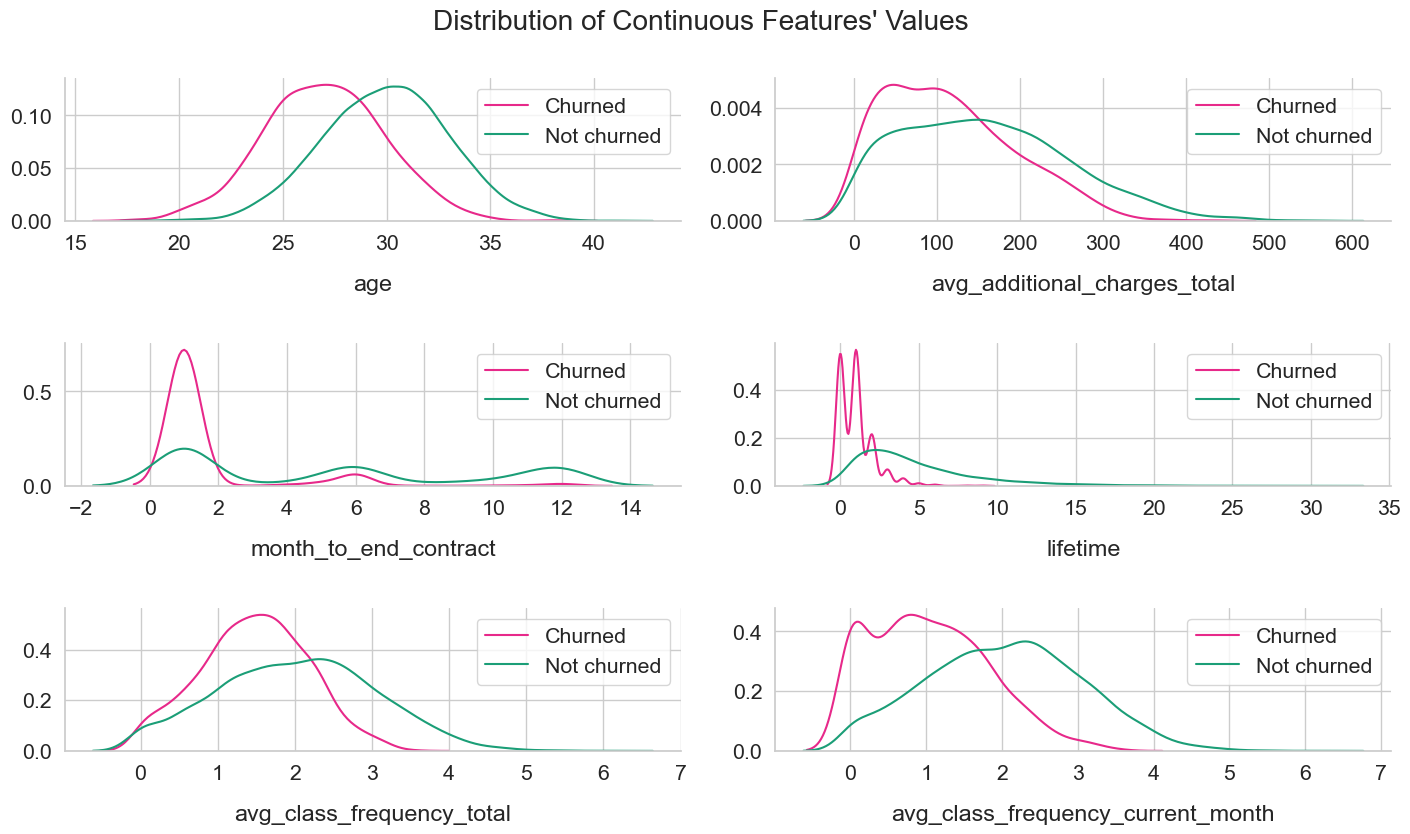

In [15]:
# Initialize the plot with specified dimensions and create a grid layout for KDE plots of numerical features
n_rows = math.ceil(len(numerical_features) / 2)
fg = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(ncols=2, nrows=n_rows, figure=fg)

# Set a title for the overall figure to describe the content
plt.suptitle("Distribution of Continuous Features' Values", y=1.03)

# Iterate over each numerical feature to create separate KDE plots for churned and not churned customers
for i in range(len(numerical_features)):
    fig_ax = fg.add_subplot(gs[y_coordinates[i], x_coordinates[i]])
    
    # Plot KDE for churned customers using a specific color for visual distinction
    array_1 = gym_df[gym_df['churn'] == 1][numerical_features[i]]
    sns.kdeplot(data=array_1, color=sns.color_palette('Dark2')[3], label='Churned')
    
    # Plot KDE for not churned customers using a different color
    array_0 = gym_df[gym_df['churn'] == 0][numerical_features[i]]
    sns.kdeplot(data=array_0, color=sns.color_palette('Dark2')[0], label='Not churned')
    
    # Configure labels for better readability and aesthetics
    plt.xlabel(xlabel=numerical_features[i], labelpad=15)
    plt.ylabel(ylabel='')
    plt.legend()
    
# Enhance plot aesthetics by removing unnecessary spines and adjusting layout to fit all elements neatly
sns.despine(bottom=False)
plt.tight_layout(pad=0.4, w_pad=1.2, h_pad=2.1)

The `age` distribution of clients who continue and have discontinued visits to the fitness center showed similar trends. The main age range for both groups is from 25 to 35 years, with peaks around 30 years. Both distributions are symmetrical and do not contain significant outliers. This indicates that age is not a significant factor influencing customer churn.

The `avg_additional_charges_total` distribution for both groups shows a slight positive skew, indicating the presence of clients who spend more than the average. For churned clients, the skew is more pronounced. Churned clients tend to have lower average expenditures, with median values around 100, whereas the average values for retained clients are around 150.

The `month_to_end_contract` feature has a multimodal distribution. This indicates that there are several groups or clusters with different mean values, each having its own distribution. Since memberships typically last for 1, 3, or 12 months, the graph shows three peaks. We can see that for churned clients, the majority of memberships were for 1 month and were not renewed. For retained clients, the groups are more evenly distributed. Each group has a normal distribution.

The `lifetime` feature for retained clients shows a normal distribution with a positive skew. Most clients attend the gym for about three months, but some have been clients for up to two years. For churned clients, the distribution is multimodal with two distinct peaks at 0 and 1 month. This indicates that a significant number of clients stop attending after the first month or do not renew their membership after the first visit.

The distributions for the `avg_class_frequency_total` and `avg_class_frequency_current_month` features are very similar. Both groups exhibit a normal distribution with symmetrical distribution around the mean. There is a difference in the distribution of the `avg_class_frequency_current_month` feature among churned clients - the distribution has two peaks at 0 and 1, meaning that churned clients attended group classes mostly once a week or not at all. Retained clients attend group classes more frequently - about 3 times a week.

While the KDE plots provided valuable information about data distribution and highlighted key differences between customer groups, they do not fully capture data variability, outliers, and median values. To better understand these aspects, we will create box plots for the same features.

Box plots will help us:

Visualize medians and quartile values, giving insight into central tendencies and data spread.
Identify outliers that may influence analysis and interpretation.
Compare data variability between customer groups (retained and churned).
These visualizations will complement the KDE plots and provide a more comprehensive view of the data, aiding in decision-making and the development of customer retention strategies.

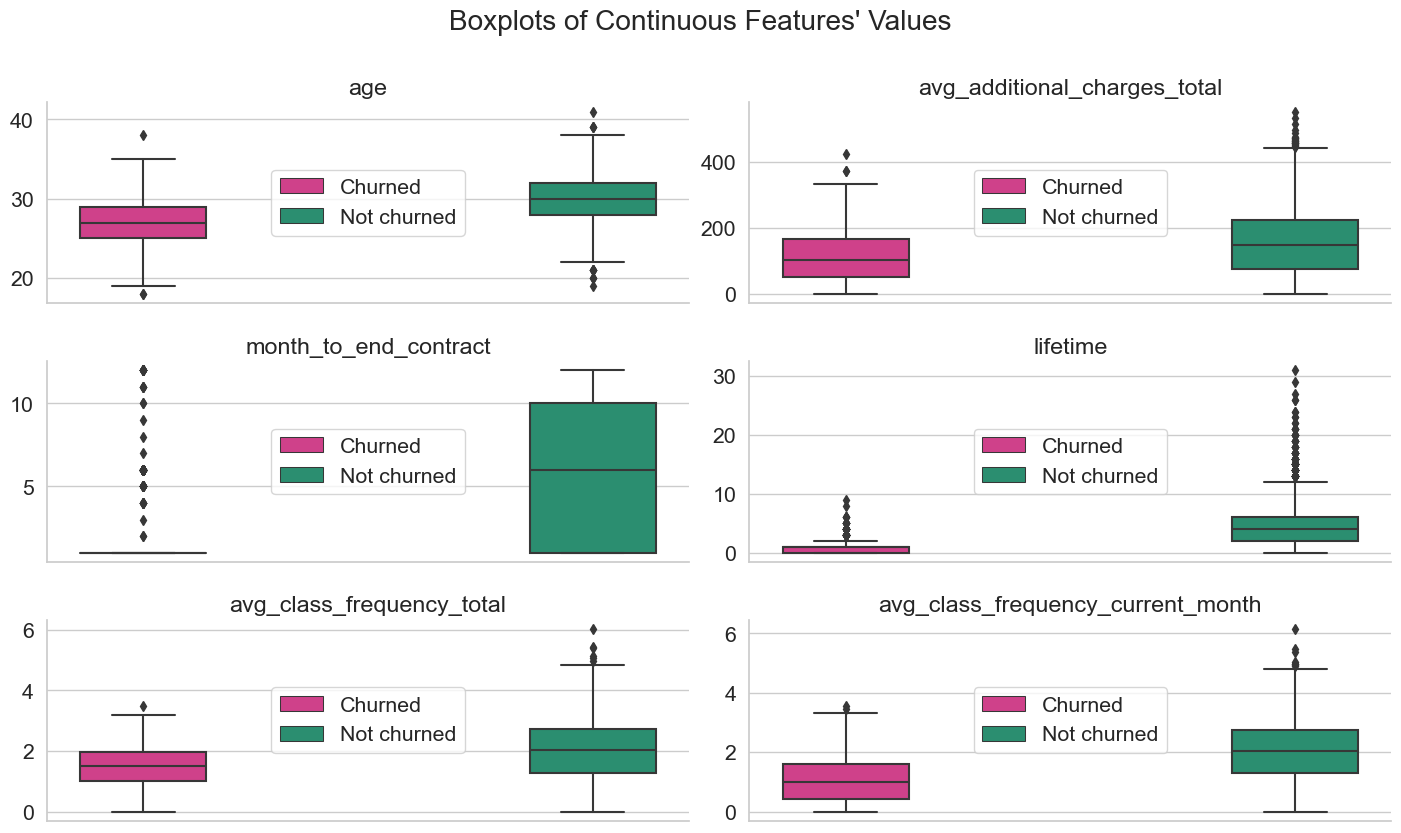

In [16]:
fg = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(ncols=2, nrows=3, figure=fg)

df_for_plot = gym_df.copy()
df_for_plot['churn'] = df_for_plot['churn'].map({0: 'Not churned', 1: 'Churned'})

# Set the main title of the figure with a specific vertical offset
plt.suptitle("Boxplots of Continuous Features' Values", y=1.03)
for i in range(len(numerical_features)):
    fig_ax = fg.add_subplot(gs[y_coordinates[i], x_coordinates[i]])
    sns.boxplot(y=numerical_features[i],
                x='churn',
                data=df_for_plot,
                hue='churn',
                order=['Churned', 'Not churned'],
                hue_order=['Churned', 'Not churned'],
                palette = {
                    'Churned': sns.color_palette('Dark2')[3],
                    'Not churned': sns.color_palette('Dark2')[0]                    
                })
    plt.title(numerical_features[i])
    plt.legend(loc='center')
    plt.xticks([])
    plt.xlabel('')
    plt.ylabel('')
    sns.despine(bottom=False)
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.3)

Creating box plots for the features `age`, `avg_additional_charges_total`, and `avg_class_frequency_current_month` did not provide new information, as the distribution plots already showed normal distributions without significant skewness. The box plots confirm that values up to 5 are considered normal for `avg_additional_charges_total` and `avg_class_frequency_current_month`, while values above 5 are outliers. However, these outliers are few and will not affect further analysis.

The `month_to_end_contract` feature showed peaks at 6 and 12 months in the distribution plot, which are considered outliers in the box plot. This indicates that the majority of churned clients did not renew their memberships. However, this feature does not indicate whether these memberships were initially purchased for one month.

For the `lifetime` feature, the box plot shows that values of 0 and 1 month are normal, while other values are outliers. This confirms that most clients indeed left after the first month.

Overall, it can be said that retained clients are characterized by:

- a higher average age;
- higher average expenditures on additional services and a wider range of these expenditures;
- more frequent attendance at group classes.

Now let's create a heatmap to analyze the correlation between features, and then we'll return to the `contract_period` feature, which we planned to consider later.

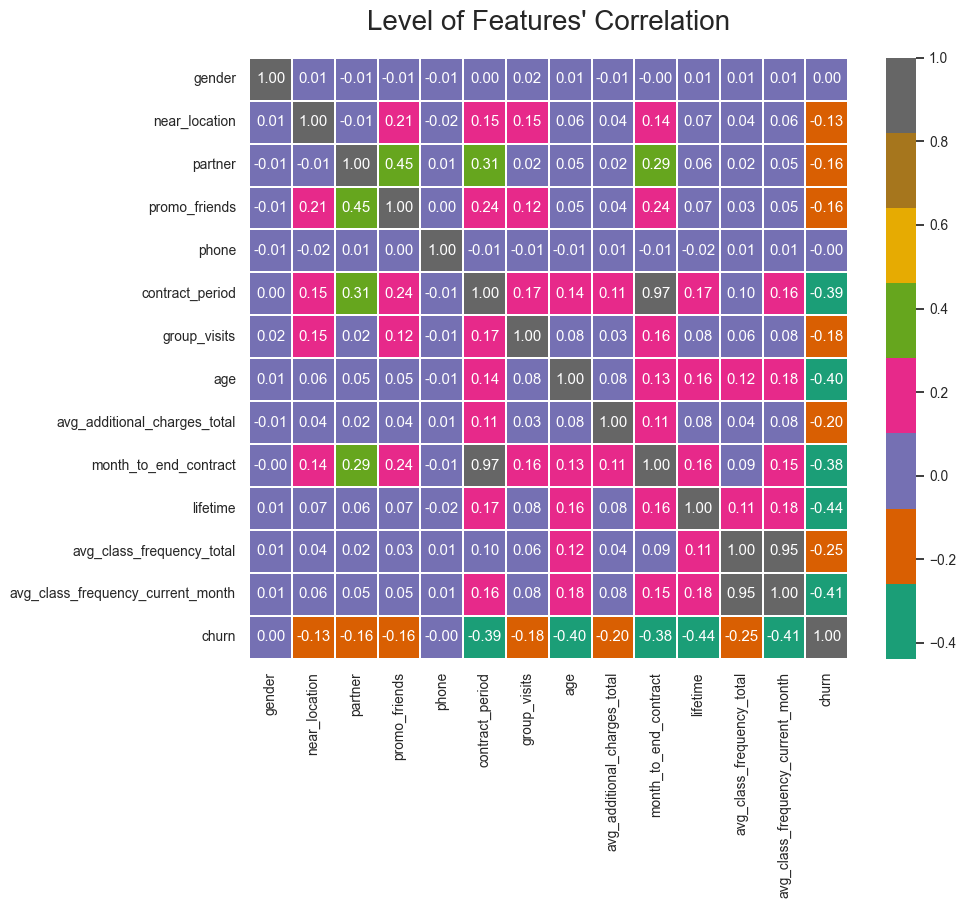

In [17]:
# Create the correlation matrix
data = gym_df.corr()

new_cmap = sns.color_palette('Dark2')

sns.set(font_scale=.9)
fg = plt.figure(figsize=(10, 9))
sns.heatmap(data,
            annot=True,
            linewidths=.2,
            cmap=new_cmap,
            fmt='.2f')
plt.title("Level of Features' Correlation", fontsize=20, pad=20)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1)

The heatmap revealed several interrelated features:

- `promo_friends` and `partner` are associated with the `contract_period` feature, which seems logical.
- connection between `promo_friends` and the `near_location` / `partner` features.

It appears that conditions for partners and the 'Bring a Friend' promotion may contribute to longer contract durations. However, this assumption requires further investigation, as correlation does not necessarily imply a choice of longer contracts.

- `month_to_end_contract` and `contract_period` features, as well `as avg_class_frequency_current_month` and `avg_class_frequency_total`, have correlation levels of 0.97 and 0.95, respectively. In fact, for the purposes of our study, these are duplicate features (their correlation with other features is almost identical).

High correlation can lead to multicollinearity issues and reduce interpretability, stability of estimates, and model accuracy.

It is recommended to remove one feature from each pair with high correlation.

**Let's check the assumption that partners and "gym friends" buy longer contracts**

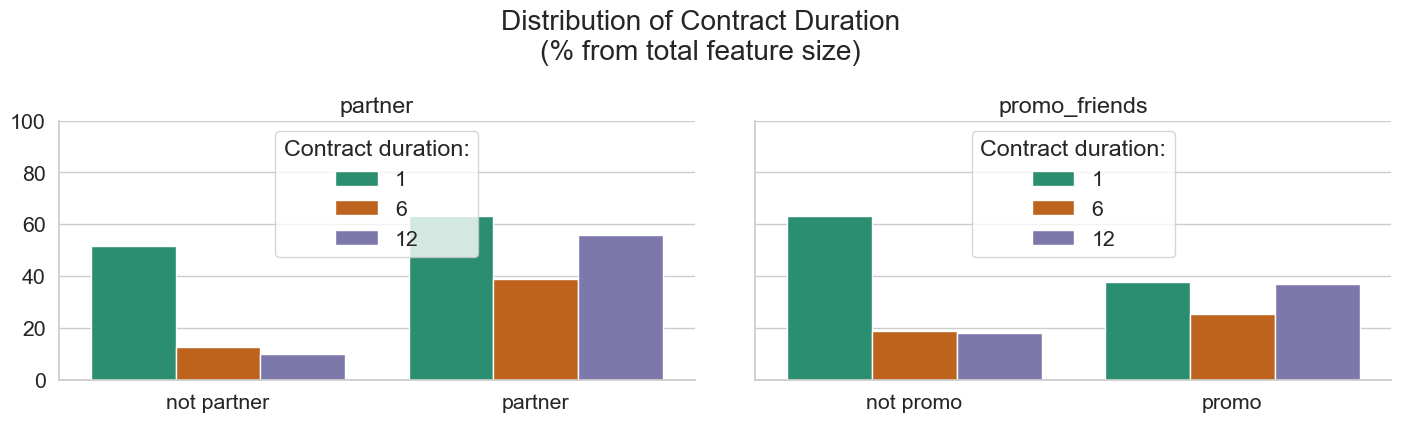

In [18]:
sns.set(style='whitegrid', font_scale=1.4)

promo_period_df = gym_df.groupby(['contract_period', 'promo_friends']).size().reset_index()
promo_period_df.rename(columns={0: 'amount'}, inplace=True)
features = ['partner', 'promo_friends']

# Let's plot the values' distribution for binary features.
n_rows = math.ceil(len(features)/2)
fg = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(ncols=2, nrows=n_rows, figure=fg)

plt.suptitle('Distribution of Contract Duration\n(% from total feature size)', y=1.03)
x_ticks = [['not partner', 'partner'], ['not promo', 'promo']]

for i in range(len(features)):
    fig_ax = fg.add_subplot(gs[y_coordinates[i], x_coordinates[i]])
    feature = features[i]
    
    promo_period_df = gym_df.groupby(['contract_period', feature]).size().reset_index()
    promo_period_df.rename(columns={0: 'amount'}, inplace=True)
    
    # Using .count()[0] and other indices in this case gives the same result due to the absence of missing values in the dataframe.
    # This approach is simpler and requires fewer resources compared to grouping data and additional merging operations.
    partners_amount = gym_df.query('promo_friends == 1').count()[0]
    not_partners_amount = gym_df.query('promo_friends == 0').count()[0]

    promo_period_df['percents'] = promo_period_df.apply(lambda row: (row['amount'
                                                                     ] / partners_amount)*100 if row[feature
                                                        ] == 1 else (row['amount'] / not_partners_amount)*100, axis=1)
    promo_period_df[feature] = promo_period_df[feature].map({0: 'no', 1: 'yes'})
    
    sns.barplot(data=promo_period_df,
                x=promo_period_df[feature],
                y=promo_period_df['percents'],
                hue=promo_period_df['contract_period'],
               palette=sns.color_palette('Dark2'))
    plt.title(feature)
    plt.ylabel('')
    plt.xlabel('')
    plt.ylim(0, 100)
    plt.xticks([0, 1], x_ticks[i])
    plt.legend(title='Contract duration:', loc='upper center')
    if i==1:
        plt.yticks(color='white')

    
sns.despine(bottom=False)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=.5)

Our assumption is correct. Among partners and clients referred by the 'bring a friend' promotion, the percentage of annual contracts is significantly higher.

**Let's remove one feature from each pair with high correlation features**

In [19]:
gym_df = gym_df.drop(['avg_class_frequency_current_month', 'month_to_end_contract'], axis=1)

numerical_features.remove('avg_class_frequency_current_month')
numerical_features.remove('month_to_end_contract')

gym_df.shape

(4000, 12)

**Exploratory Data Analysis: Summary**

The Exploratory Data Analysis (EDA) provided valuable insights into the characteristics and behaviors of fitness center clients. The main steps and findings of the analysis are summarized below:

*Actions included:*

- Studying the mean values and standard deviations;
- Analyzing mean values separately for churned and not churned clients;
- Creating barplots, KDE plots, and boxplots to visualize distributions;
- Analyzing the correlation between features.
  
*Key Findings:*

1. Mean Values and Standard Deviations:

    - Clients who continue to visit the fitness center are generally older, more frequently participate in partner programs and 'bring a friend' promotions, have longer memberships, and exhibit higher average visit frequencies;

2. Barplots:

    - Features like `phone` and `gender` do not significantly influence customer churn. The highest percentage of retained customers attend group classes (`group_visits`) and are club partners (`partner`);

3. KDE and Boxplots:
   - `age` is not a significant factor influencing customer churn;
   - the `avg_additional_charges_total` distribution shows a slight positive skew, indicating the presence of clients who spend more than the average. For churned clients, the skew is more pronounced;
   - the `month_to_end_contract` feature has a multimodal distribution, with the majority of churned clients having 1-month memberships that were not renewed;
   - the `lifetime` feature indicates that most churned clients stopped attending after the first month;
   - the `avg_class_frequency_total` and `avg_class_frequency_current_month` features have normal distributions for retained clients. For churned clients, there are peaks at 0 and 1, indicating that they attended group classes mostly once a week or not at all.

4. Correlation Analysis:
    - the `promo_friends` and `partner` features are associated with `contract_period`, suggesting that conditions for partners and the 'Bring a Friend' promotion may contribute to longer contract durations;
    - there is a high correlation between the `month_to_end_contract` and `contract_period` features (0.97), as well as between the `avg_class_frequency_current_month` and `avg_class_frequency_total` features (0.95). These features can be considered duplicates.
    - high correlation can lead to multicollinearity issues, reducing interpretability and model accuracy. One feature from each pair with high correlation was removed.

<a id='customerchurnpredictionmodel'></a>
[*<< to Exploratory Data Analysis*](#eda)

## Customer Churn Predict Model.

**Actions included:**

- Splitting the data into training and validation sets using the train_test_split() function;
- Training the models;
- Evaluating the following metrics:

    - `Accuracy` - the percentage of correct predictions out of all predictions;
    - `Precision` - the percentage of true positive predictions out of all predicted positives;
    - `Recall` - the percentage of true positive predictions out of all actual positive cases;
    - `F1 Score` - the harmonic mean of precision and recall, providing a balance between these two metrics.
- Comparing the models based on these metrics to determine which model performs better.

[*>> to Customer Segmentation through Clustering*](#customerclustering)

In [20]:
# Split the data into features (variable X) and the target variable (y)
X = gym_df.drop('churn', axis=1).copy()
y = gym_df['churn'].copy()

# Split the data into training and validation sets
# Setting random_state=0 ensures that the split is reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

For building the customer churn prediction model, two algorithms were chosen:

- `Logistic Regression` - a basic and widely used method for binary classification tasks, which is easy to interpret. The algorithm performs well on simple datasets and trains quickly;
- `Random Forest` - a powerful ensemble method capable of capturing complex relationships between features. This method is resistant to overfitting and performs well on a variety of datasets.

These models cover the fundamental concepts of machine learning, providing a balance between simplicity, interpretability, and power.

In [21]:
# Creating model objects
models_dict = {
    'LogisticRegression': LogisticRegression(solver='liblinear', random_state=0),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=75, random_state=0)
}

# Function for training the model and making predictions
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return [
        round(accuracy_score(y_test, predictions) * 100, 2),
        round(precision_score(y_test, predictions) * 100, 2),
        round(recall_score(y_test, predictions) * 100, 2),
        round(f1_score(y_test, predictions) * 100, 2)
    ]

# List to store prediction results
results = []

for model_name, model in models_dict.items():
    metrics = make_prediction(model, X_train, y_train, X_test, y_test)
    metrics.append(model_name)
    results.append(metrics)

# Creating DataFrame with prediction metrics
prediction_df = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1', 'Algorithm'])

# Sorting DataFrame by 'F1' score in descending order and setting 'Algorithm' as the index
prediction_df = prediction_df.sort_values('F1', ascending=False).set_index('Algorithm')

# Display DataFrame
prediction_df

,Accuracy,Precision,Recall,F1
Algorithm,,,,
RandomForestClassifier,89.62,79.79,77.78,78.77
LogisticRegression,88.38,76.12,77.27,76.69


The comparison of models shows that the Random Forest outperformed Logistic Regression in most metrics. While Logistic Regression has slightly better `recall`, Random Forest excels in `accuracy`, `precision`, and `F1 score`. This indicates a higher ability of the Random Forest model to correctly classify both positive and negative examples. Therefore, Random Forest is the more preferable model for the customer churn prediction task.

Now we will try to tune the models by adding additional parameters to improve their performance.

For Logistic Regression, we will add the penalty='l1' parameter, which uses L1 regularization. This regularization can help reduce overfitting and improve model interpretability by potentially setting some coefficients to zero, leading to feature selection.
For Random Forest, we will add the min_samples_split=10 parameter, which specifies the minimum number of samples required to split an internal node. This can help prevent overfitting by ensuring that nodes do not split too finely.
Adding these parameters should enhance accuracy, precision, recall, and the F1 score, making the models more stable and accurate.

In [22]:
# Creating tuned model objects
tuned_models_dict = {
    'LogisticRegression': LogisticRegression(penalty='l1', solver='liblinear', random_state=0),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=75, min_samples_split=20, random_state=0)
}

# List to store prediction results
results = []

for model_name, model in tuned_models_dict.items():
    metrics = make_prediction(model, X_train, y_train, X_test, y_test)
    metrics.append(model_name)
    results.append(metrics)

# Creating DataFrame with prediction metrics
tuned_prediction_df = pd.DataFrame(results, columns=['Accuracy', 'Precision', 'Recall', 'F1', 'Algorithm'])

# Sorting DataFrame by 'F1' score in descending order and setting 'Algorithm' as the index
tuned_prediction_df = tuned_prediction_df.sort_values('F1', ascending=False).set_index('Algorithm')

tuned_prediction_df

,Accuracy,Precision,Recall,F1
Algorithm,,,,
RandomForestClassifier,90.12,82.16,76.77,79.37
LogisticRegression,89.50,77.94,80.30,79.10


**Customer Churn Predict Model: Summary**

Initial Model Performance
Initially, we built two models to predict customer churn: Logistic Regression and Random Forest. The Random Forest model outperformed Logistic Regression in most metrics, while Logistic Regression had slightly better recall.

Model Tuning
To enhance model performance, we adjusted their hyperparameters. Logistic Regression was improved with L1 regularization for feature selection and reducing overfitting. Random Forest was tuned with the parameter min_samples_split=20 to prevent the creation of very small leaves.

After tuning, both models showed improvement. Random Forest saw gains in accuracy and precision, while Logistic Regression improved in recall and F1 score.

Conclusion
After tuning, the Random Forest model remains the preferred choice for predicting customer churn due to its balanced performance across all metrics, although Logistic Regression also showed improved results. its balanced performance across all metrics.


[*<< to Customer Churn Prediction Model*](#customerchurnpredictionmodel)

<a id='customerclustering'></a>
## Customer Segmentation through Clustering

**Actions included:**

- Standardizing the data:
    - Standardizing numerical features to ensure they have a mean of 0 and a standard deviation of 1.
    - Binarizing categorical features where necessary.

- Constructing a distance matrix and dendrogram;

- Training the K-Means clustering model;

- Analyzing the mean values of features for each cluster;

- Plotting the distributions of features for each cluster;

- Calculating the churn rate for each cluster.

[*>> to Project Sumary*](#projectsumary)

We will use the *pd.get_dummies* method to efficiently process the contract_period feature:

- *One-Hot Encoding* - This will convert the `contract_period` feature into multiple binary features. By doing this, we ensure that the algorithm can correctly account for all categories without any ordinal relationship implied. After this transformation, all features will either be numerical or binary, allowing for a consistent standardization process.

In [23]:
# Apply One-Hot Encoding to the contract_period feature
contract_period_dummies = pd.get_dummies(X['contract_period'])

# Remove the original contract_period feature from the DataFrame
X = X.drop('contract_period', axis=1)

# Combine the result with the remaining features
X_dummies = pd.concat([X, contract_period_dummies], axis=1)

# Convert column names to strings
X_dummies.columns = X_dummies.columns.astype(str)

X_dummies.head()

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,1,6,12
0,1,1,1,1,0,1,29,14.227470,3,0.020398,0,1,0
1,0,1,0,0,1,1,31,113.202938,7,1.922936,0,0,1
2,0,1,1,0,1,0,28,129.448479,2,1.859098,1,0,0
3,0,1,1,1,1,1,33,62.669863,2,3.205633,0,0,1
4,1,1,1,1,1,0,26,198.362265,3,1.113884,1,0,0


In [24]:
sc = StandardScaler()
X_sc = sc.fit_transform(X_dummies)

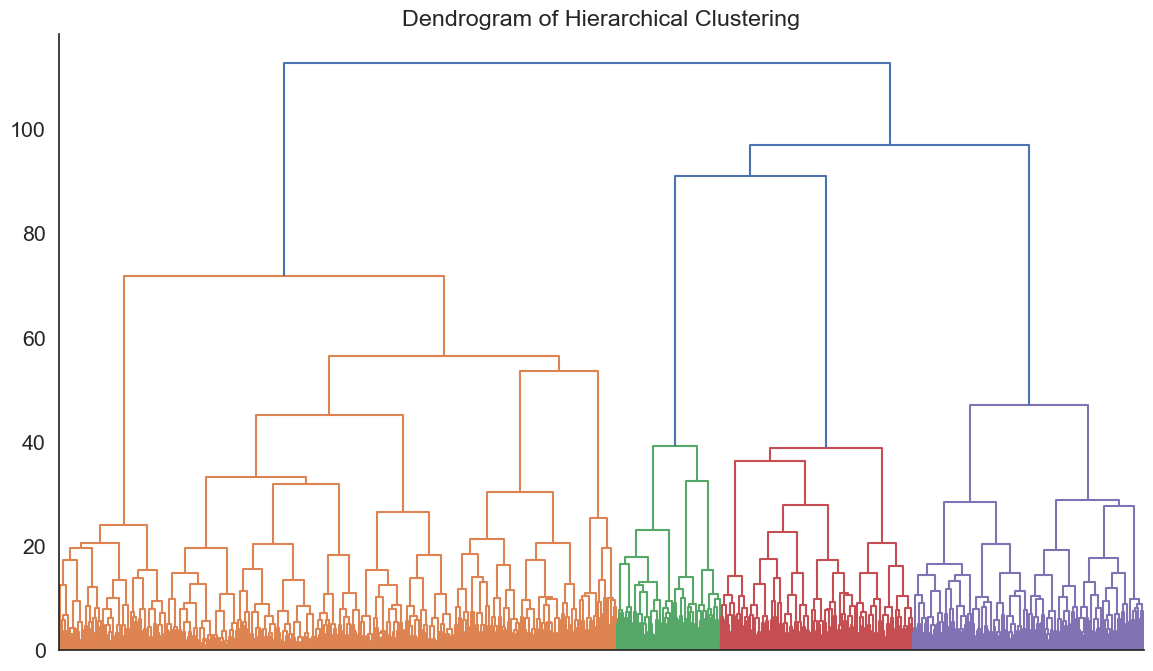

In [25]:
sns.set(style='white',font_scale=1.4)
Z = linkage(X_sc, 'ward', optimal_ordering=True)
fig = plt.figure(figsize=(14, 8))
dendrogram(Z, orientation='top')
plt.title('Dendrogram of Hierarchical Clustering')
plt.xticks([])

sns.despine(bottom=False)

plt.show()

The dendrogram clearly shows four clusters, which is supported by the visual distinctiveness and color separation. Attempting to identify additional clusters might complicate the interpretation of results without substantial benefits. Therefore, for further analysis, we will decide to divide the data into four clusters.

**Now, we will apply the K-Means algorithm to the same standardized matrix, setting the number of clusters to four, and analyze the results.**

In [33]:
# Create and learn model
km = KMeans(n_clusters=4, random_state=0, n_init='auto')
labels = km.fit_predict(X_sc)

# Add cluster labels to the original data
gym_df['cluster'] = labels
gym_df.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn,cluster
0,1,1,1,1,0,6,1,29,14.227470,3,0.020398,0,1
1,0,1,0,0,1,12,1,31,113.202938,7,1.922936,0,3
2,0,1,1,0,1,1,0,28,129.448479,2,1.859098,0,2
3,0,1,1,1,1,12,1,33,62.669863,2,3.205633,0,3
4,1,1,1,1,1,1,0,26,198.362265,3,1.113884,0,0


In [34]:
# Analyzing the mean values of features for each cluster
cluster_means = gym_df.groupby('cluster').mean()
cluster_means

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_total,churn
cluster,,,,,,,,,,,,
0,0.532609,0.980978,0.377717,0.322464,0.908514,1.00000,0.536232,30.305254,160.721220,4.539855,2.085602,0.176630
1,0.516206,0.861945,0.575030,0.374550,0.895558,6.00000,0.441777,29.548619,151.647734,4.138055,1.945273,0.124850
2,0.484163,0.619910,0.330317,0.097738,0.904977,1.01991,0.150226,27.228959,115.104563,1.778281,1.504180,0.670588
3,0.509395,0.934238,0.716075,0.478079,0.902923,12.00000,0.545929,29.830898,163.701022,4.671190,2.015703,0.021921


Based on the analysis of the dendrogram, we decided to divide the data into four clusters, as this number of clusters allows us to see clear differences between groups of customers. Applying the K-Means algorithm, we obtained the following results: one cluster (Cluster 3) shows the lowest churn rate, while another (Cluster 2) shows the highest churn rate. This confirms that this clustering helps to identify significant differences in customer loyalty and can be useful for further analysis and developing customer retention strategies.

**Plotting the distributions of features for each cluster:**

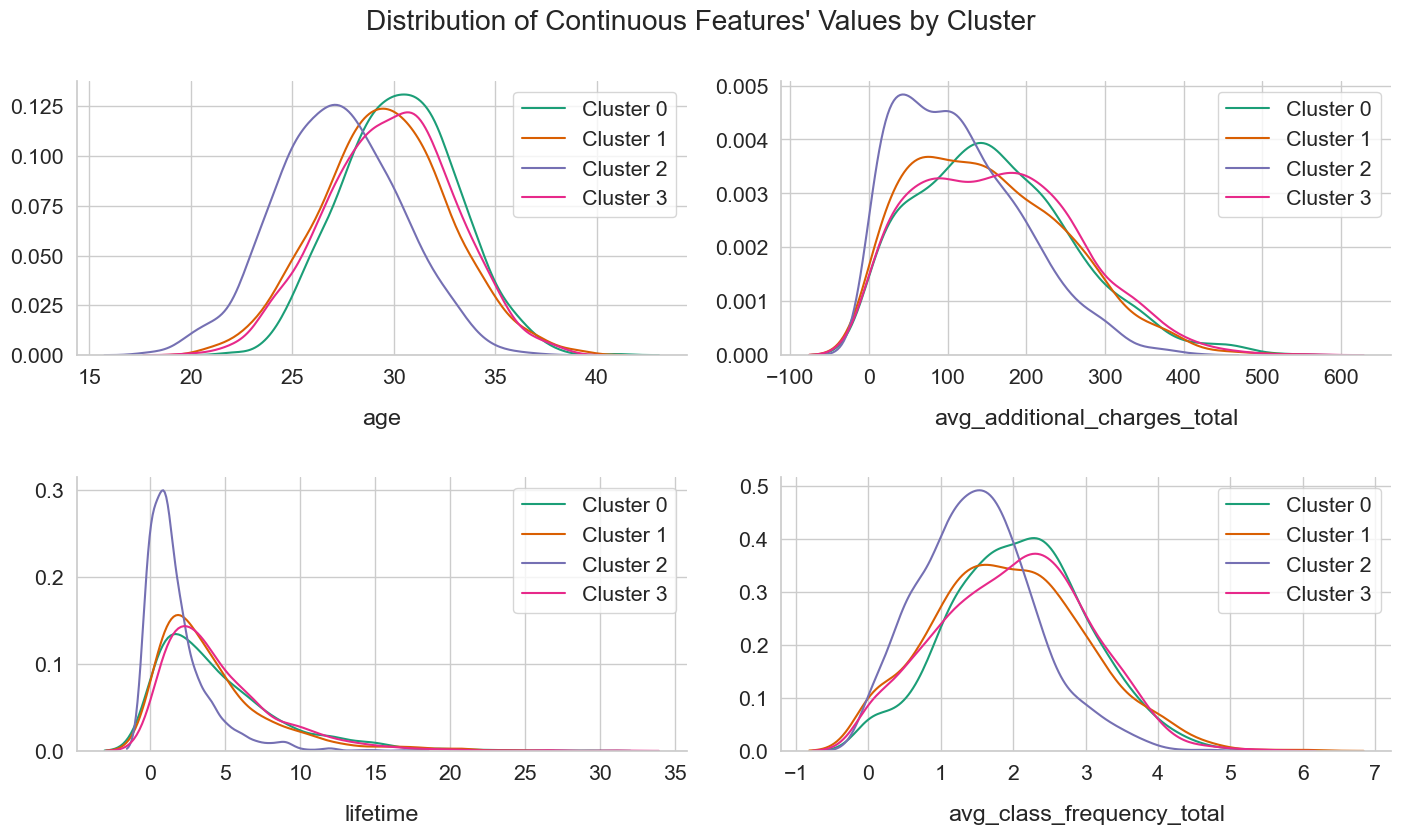

In [35]:
sns.set(style='whitegrid', font_scale=1.4)
# Define the number of rows for the subplot grid
n_rows = math.ceil(len(numerical_features) / 2)
fg = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(ncols=2, nrows=n_rows, figure=fg)

# Set the title for the overall figure
plt.suptitle("Distribution of Continuous Features' Values by Cluster", y=1.03)

# Iterate over each numerical feature to create separate KDE plots for each cluster
for i in range(len(numerical_features)):
    fig_ax = fg.add_subplot(gs[y_coordinates[i], x_coordinates[i]])
    
    # Loop through each cluster and plot the KDE for each
    for j in range(4):  # Assuming 4 clusters
        cluster_data = gym_df[gym_df['cluster'] == j][numerical_features[i]]
        sns.kdeplot(data=cluster_data, color=sns.color_palette('Dark2')[j], label=f'Cluster {j}')
    
    # Configure labels for better readability and aesthetics
    plt.xlabel(xlabel=numerical_features[i], labelpad=15)
    plt.ylabel(ylabel='')
    plt.legend()

# Enhance plot aesthetics by removing unnecessary spines and adjusting layout to fit all elements neatly
sns.despine(bottom=False)
plt.tight_layout(pad=0.4, w_pad=1.2, h_pad=2.1)

# Display the plot
plt.show()


The clustering results indeed align well with the findings from the EDA. This confirms that the clusters we identified exhibit significant differences in customer behavior and loyalty levels. It is important that both methods—EDA and clustering—provide consistent and useful information for developing customer retention strategies.

Now let's evaluate the quality of clustering using the silhouette coefficient metric with the `silhouette_score` method.

In [29]:
round(silhouette_score(X_sc, labels),4)

0.137

Although the overall silhouette score indicates cluster mixing, it is important to note that the cluster of churned customers is well-separated, as seen in the distribution plots. This confirms that the key characteristics influencing churn can be identified and utilized for further analysis and prediction. Primary attention should be given to the characteristics of churned customers to develop effective retention strategies.

**Calculating the churn rate for each cluster:**

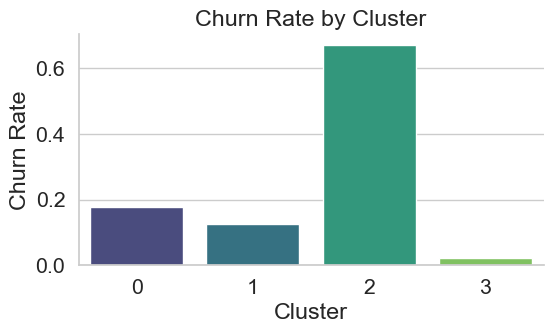

In [30]:
# Group by clusters and calculate the mean churn rate for each cluster
churn_rate_per_cluster = gym_df.groupby('cluster')['churn'].mean().reset_index()

# Create a bar plot
plt.figure(figsize=(6, 3))
sns.barplot(x='cluster', y='churn', data=churn_rate_per_cluster, palette='viridis')

# Add titles and labels
plt.title('Churn Rate by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Churn Rate')
sns.despine(bottom=False)
# Display the plot
plt.show()

**Customer Segmentation through Clustering: Summary**

We conducted customer segmentation using clustering to better understand their behavior and identify groups with varying levels of loyalty. Here are the key steps and conclusions:

- *Standardizing the data*:
  - Numerical features were standardized to have a mean of 0 and a standard deviation of 1.
  - The categorical feature `contract_period` was transformed using One-Hot Encoding.

- *Constructing a distance matrix and dendrogram*:
  - We built a distance matrix and dendrogram to determine the optimal number of clusters. Based on the dendrogram analysis, we decided to divide the data into four clusters.

- *Training the K-Means clustering model*:
  - The K-Means algorithm was applied to the standardized data, resulting in the formation of four distinct clusters.

- *Analyzing the mean values of features for each cluster*:
  - Analyzing the mean values for each cluster revealed significant differences in the behavior and characteristics of clients, especially for Cluster 2, which has the highest churn rate.

- *Plotting the distributions of features for each cluster*:
  - Distribution plots confirmed differences between the clusters, particularly highlighting Cluster 2 with the highest customer churn.

- *Calculating the churn rate for each cluster*:
  - Cluster 2 showed the highest churn rate (67%), emphasizing its vulnerability. Meanwhile, Cluster 3 had the lowest churn rate (2.1%).

Overall Conclusions:

Clustering allowed us to identify groups of clients with different levels of loyalty and behavior. This aligns with the results of our initial exploratory data analysis and provides additional insights for developing effective customer retention strategies.


<a id='projectsumary'></a>
## Project Summary

The main goal of the project is to learn to predict the probability of customer churn (at the next month level) for each client.

**Actions Taken:**
- Identified typical customer profiles;
- Analyzed the main features impacting churn.

We used several approaches to identify different groups of customers, allowing us to more accurately characterize their key properties.

**Exploratory Data Analysis**

As part of the EDA, we analyzed the distribution of numerical features and the percentage of customers based on binary features separately for churned and retained customers. This allowed us to identify several key characteristics:

- The churn rate is lower among:
    - those who live nearby;
    - those who joined through partner programs and/or promotions;
    - customers who regularly attend group classes.
- Customers likely to churn:
    - are younger on average - around 27 years old;
    - spend less on additional services on average;
    - attend group classes less frequently than other customers.
- Among customers who joined through partner programs and/or promotions, the duration of the contract is often longer.

**Customer Churn Predict Model**

To build the customer churn prediction model, we used two algorithms: Logistic Regression and Random Forest. Logistic Regression was chosen as a basic and widely used method for binary classification tasks, as it is easy to interpret and performs well on simple datasets. Random Forest was chosen as a powerful ensemble method capable of capturing complex relationships between features and resistant to overfitting.

These models were trained and tuned, yielding the following results:

<table width="100%">
  <tr>
    <th><b>Algorithm</b></th>
    <th><b>Accuracy</b></th>
    <th><b>Precision</b></th>
    <th><b>Recall</b></th>
    <th><b>F1</b></th>
  </tr>
  <tr>
    <td>RandomForestClassifier</td>
    <td align="center">90.12</td>
    <td align="center">82.16</td>
    <td align="center">76.77</td>
    <td align="center">79.37</td>
  </tr>
  <tr>
    <td>LogisticRegression</td>
    <td align="center">89.50</td>
    <td align="center">77.94</td>
    <td align="center">80.30</td>
    <td align="center">79.10</td>
  </tr>
</table>

The analysis of metrics shows that both models demonstrate good results. Random Forest showed the best accuracy and precision, while Logistic Regression slightly outperformed in recall. However, overall, both models have similar F1 scores, indicating their balanced performance.

**Customer Segmentation through Clustering**

The third method for predicting customer churn involves clustering customers and identifying key features that have the greatest impact on churn. In this task, we standardized the data, created a distance matrix, and built a dendrogram for visual assessment of the possible number of clusters. Then, using the K-Means algorithm, we divided the data into clusters, choosing the number of clusters to be four.

Clustering did not reveal distinct characteristics for customers likely to stay, but it clearly identified the cluster prone to churn. By studying the mean values for each cluster, we observed that the distribution of numerical features for customers in cluster 2 matched those in the "churned" group from the EDA stage.

*Customers likely to churn:*
- are younger;
- spend less on additional services on average;
- attend group classes less frequently than other customers.

**Recommendations:**

Based on data analysis and clustering results, the following recommendations are proposed:

- Consider increasing the proportion of customers who join through partner programs and promotions, as they show lower churn rates;
- Analyze and improve services related to group classes, as regular attendance reduces the likelihood of customer churn;
- Encourage the signing of longer-term contracts.